# Problem 1 -> Metropolis Hasting Algorithm using Rayleigh Distribution

In [86]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib as mp
import plotly
import matplotlib.pyplot 
import seaborn as sns
import emcee
import math
from numpy import linalg as la
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time
from scipy.stats import rayleigh

In [353]:
# Metropolis hasting algorithm  for Rayleigh distribution
import numpy as np
import matplotlib.pyplot as pl

def f(x):
    return rayleigh.rvs(1000)

def metro_hast():
    N = 100000
    x = np.arange(N,dtype=np.float)

    x[0] = 0.2
    counter = 0
    for i in range(0, N-1):
        
        x_next = np.random.normal(x[i], 1.)
        if np.random.random_sample() < min(1, f(x_next)/f(x[i])):
            x[i+1] = x_next
            counter = counter + 1
        else:
            x[i+1] = x[i]

    print("acceptance fraction is ", counter/float(N))

    pl.hist(x, bins=50, color='blue')
    pl.show()
    


acceptance fraction is  0.99965


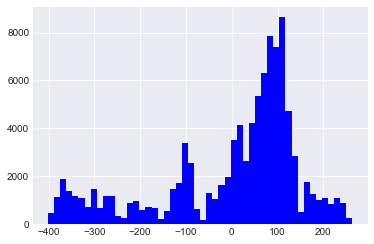

In [354]:
metro_hast()

# Problem 1 - Gibbs sampling for bivariate normal distribution

C:\Users\anmol\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



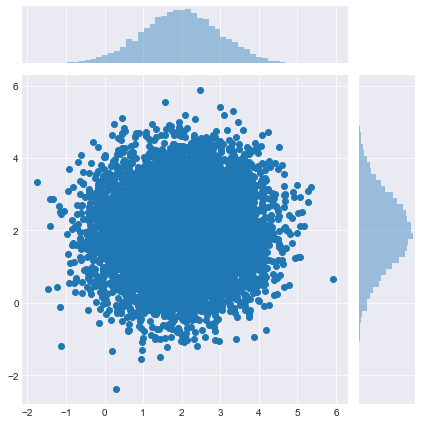

In [355]:
import numpy as np
import seaborn as sns


def p_x_given_y(y, mus, sigmas):
    mu = mus[0] + sigmas[1, 0] / sigmas[0, 0] * (y - mus[1])
    sigma = sigmas[0, 0] - sigmas[1, 0] / sigmas[1, 1] * sigmas[1, 0]
    return np.random.normal(mu, sigma)


def p_y_given_x(x, mus, sigmas):
    mu = mus[1] + sigmas[0, 1] / sigmas[1, 1] * (x - mus[0])
    sigma = sigmas[1, 1] - sigmas[0, 1] / sigmas[0, 0] * sigmas[0, 1]
    return np.random.normal(mu, sigma)


def gibbs_sampling(mus, sigmas, iter=10000):
    samples = np.zeros((iter, 2))
    y = np.random.rand() * 10

    for i in range(iter):
        x = p_x_given_y(y, mus, sigmas)
        y = p_y_given_x(x, mus, sigmas)
        samples[i, :] = [x, y]

    return samples


if __name__ == '__main__':
    mus = np.array([2, 2])
    sigmas = np.array([[1, 0], [0, 1]])

    samples = gibbs_sampling(mus, sigmas)
    sns.jointplot(samples[:, 0], samples[:, 1])

# Problem 2 - 9.6 & 9.12 from Rizzo

# 9.6

In [187]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')


sizes = np.r_[125, 18, 20, 34]
np.random.seed(1)
theta = np.random.rand(10)
t = np.r_[2+theta, (1-theta), theta]/4
dg = sizes[0]*t[0] + sizes[1]*t[1] + sizes[2]*t[2] + sizes[3]*t[3]
dg = np.floor(dg)
print (dg)

117.0


In [211]:
data = np.random.multinomial(117,t*0.1)

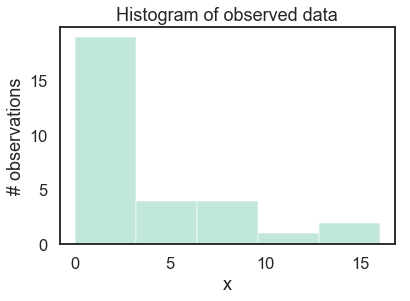

In [212]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

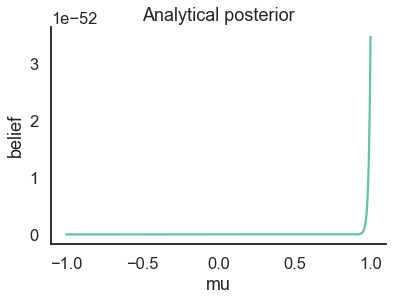

In [213]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

In [214]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

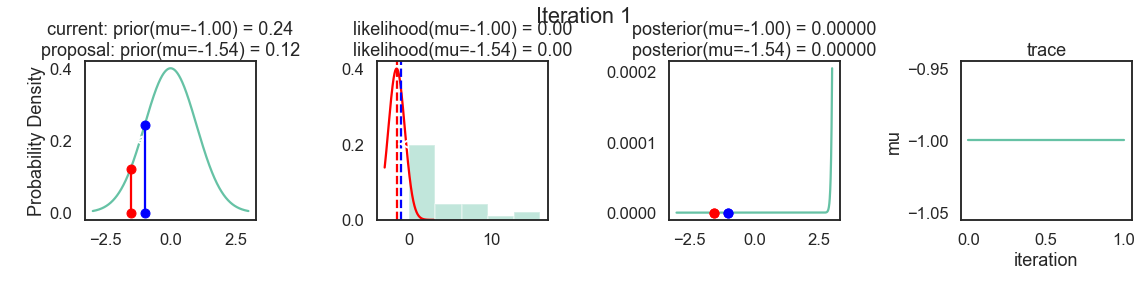

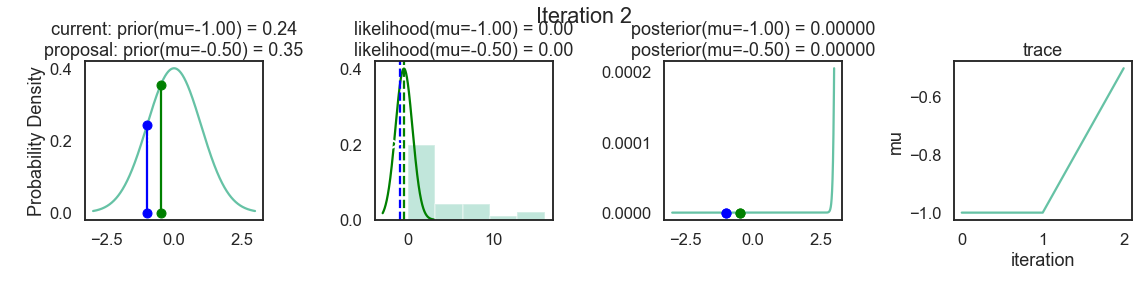

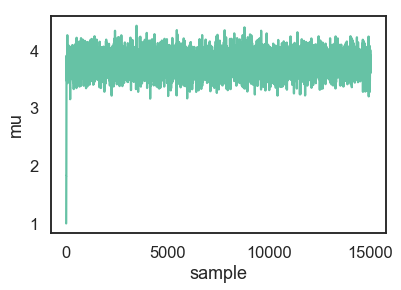

In [215]:
np.random.seed(123)
sampler(data, samples=2, mu_init=-1., plot=True);
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

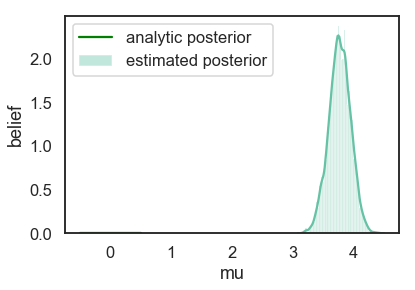

In [219]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

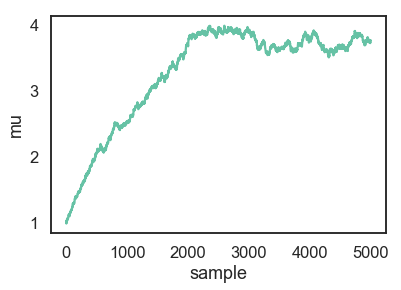

In [220]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

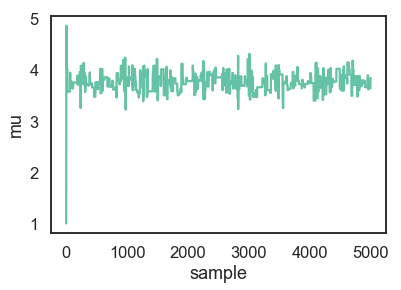

In [221]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');


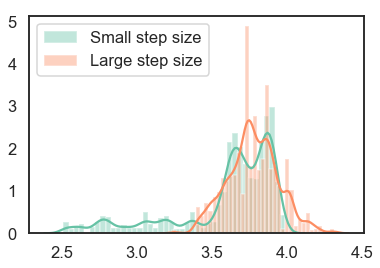

In [222]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains: 100%|████████████████████████████████████████████████████| 31000/31000 [00:20<00:00, 1540.21draws/s]
The number of effective samples is smaller than 25% for some parameters.


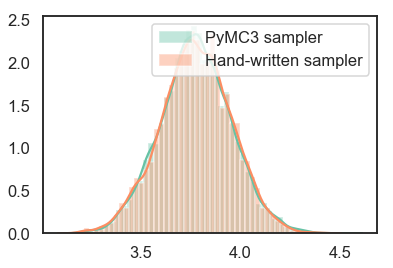

In [223]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)
    
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
sns.distplot(posterior[500:], label='Hand-written sampler');
plt.legend();

# 9.12


In [224]:
pymc3.diagnostics.gelman_rubin(trace, varnames=None, include_transformed=False)


{'mu': 0.9999666664461573}

In [227]:
chain1 = sampler(data,samples=15000,mu_init=3,proposal_width=2,
                mu_prior_mu=mu_prior,mu_prior_sd = sigma_prior)
chain2 = sampler(data,samples=15000,mu_init=3,proposal_width=2,
                mu_prior_mu=mu_prior,mu_prior_sd = sigma_prior)

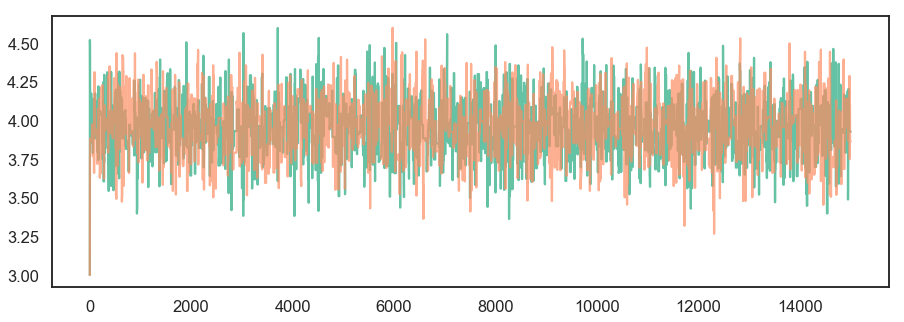

In [228]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(15001),chain1)
plt.plot(np.arange(15001),chain2,alpha=.7)

In [231]:
chain1 = sampler(data,samples=10000,mu_init=3,proposal_width=3,
                mu_prior_mu=mu_prior,mu_prior_sd = sigma_prior)
chain2 = sampler(data,samples=10000,mu_init=3,proposal_width=2,
                mu_prior_mu=mu_prior,mu_prior_sd = sigma_prior)
chain3 = sampler(data,samples=10000,mu_init=3,proposal_width=1,
                mu_prior_mu=mu_prior,mu_prior_sd = sigma_prior)

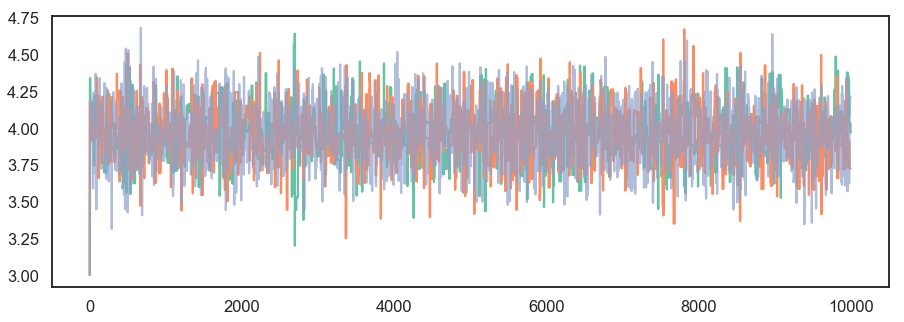

In [232]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(10001),chain1)
plt.plot(np.arange(10001),chain2)
plt.plot(np.arange(10001),chain3,alpha=.7)

# Problem 3 - 9.8 and 9.9 from Rizzo

Efficiency =  0.1799
Gelmen-Rubin Diagnostic:  1.085379342795298


C:\Users\anmol\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Users\anmol\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



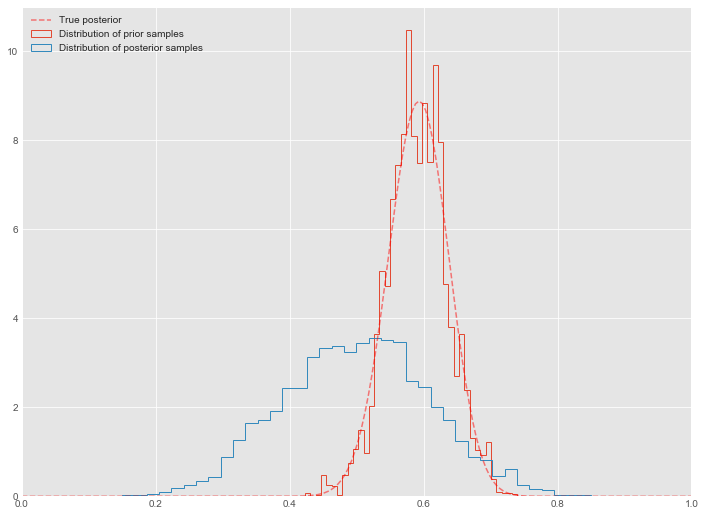

In [376]:
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

n = 100
h = 61
a = 10
b = 10
lik = st.binom
prior = st.beta(a, b)
sigma = 0.3

naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
for i in range(niters):
    theta_p = theta + st.norm(0, sigma).rvs()
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2
print ("Efficiency = ", naccept/niters)


def sampler(niters, n, h, theta, lik, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + stats.norm(0, sigma).rvs()
        rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)
    return samples
samples_sample = [sampler(niters, n, h, theta, lik, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]

# Gelmen-Rubin Diagnostic
mean1 = np.mean(u)
B = n * ((mean1)**2)
var_theta = (1 - 1/n) * u + 1/n*B
print("Gelmen-Rubin Diagnostic: ", np.sqrt(var_theta/u))
post = st.beta(h+a, n-h+b)

plt.figure(figsize=(12, 9))
plt.hist(samples[nmcmc:], 40, histtype='step', normed=True, linewidth=1, label='Distribution of prior samples');
plt.hist(prior.rvs(nmcmc), 40, histtype='step', normed=True, linewidth=1, label='Distribution of posterior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best');



In [383]:
samples_sample



[[0.1,
  0.1,
  0.1,
  0.1,
  0.8201209608055728,
  0.8201209608055728,
  0.8201209608055728,
  0.8201209608055728,
  0.8171077522191379,
  0.5934242387861504,
  0.5934242387861504,
  0.5934242387861504,
  0.5934242387861504,
  0.5934242387861504,
  0.5934242387861504,
  0.5934242387861504,
  0.5934242387861504,
  0.5459450923061495,
  0.5459450923061495,
  0.5459450923061495,
  0.5459450923061495,
  0.5459450923061495,
  0.5459450923061495,
  0.5459450923061495,
  0.5459450923061495,
  0.5459450923061495,
  0.5459450923061495,
  0.5459450923061495,
  0.5206180115104235,
  0.5206180115104235,
  0.611873400282438,
  0.6365041218507299,
  0.6365041218507299,
  0.6365041218507299,
  0.6365041218507299,
  0.6365041218507299,
  0.6365041218507299,
  0.6508510007254013,
  0.6727363871952183,
  0.6727363871952183,
  0.5199135432679094,
  0.5199135432679094,
  0.5199135432679094,
  0.5199135432679094,
  0.5199135432679094,
  0.5199135432679094,
  0.5199135432679094,
  0.5199135432679094,
  0.5

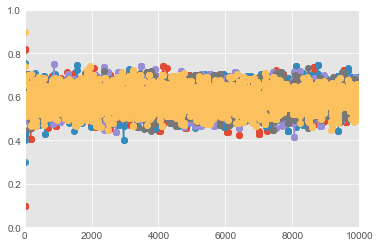

In [377]:
for samples in samples_sample:
    plt.plot(samples, '-o')
plt.xlim([0, niters])
plt.ylim([0, 1]);

# Problem 2 - 9.12 from Rizzo - Alternate Method

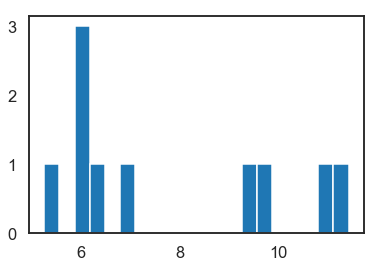

In [3]:
%matplotlib inline
import numpy as np
from scipy.stats import norm,uniform
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

np.random.seed(282629734)

sbn.set_style('white')
sbn.set_context('talk')
data = norm(10,3).rvs(10)
sigma = 0.2       # Note this is the std of x
mu_prior = 8
sigma_prior = 1.5  # Note this is our prior on the std of mu

plt.hist(data,bins=20)
plt.show()

In [4]:
def sampler(data, samples=4, mu_init=9, sigma= 0.2, proposal_width=3, 
            mu_prior_mu=10, mu_prior_sd=1):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, sigma).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, sigma).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        c = np.min((1,p_proposal / p_current))
        
        accept = np.random.rand() <= c
                
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

In [5]:
chain = sampler(data,samples=15000,mu_init=9,sigma=sigma,proposal_width=2,
                mu_prior_mu=mu_prior,mu_prior_sd = sigma_prior)

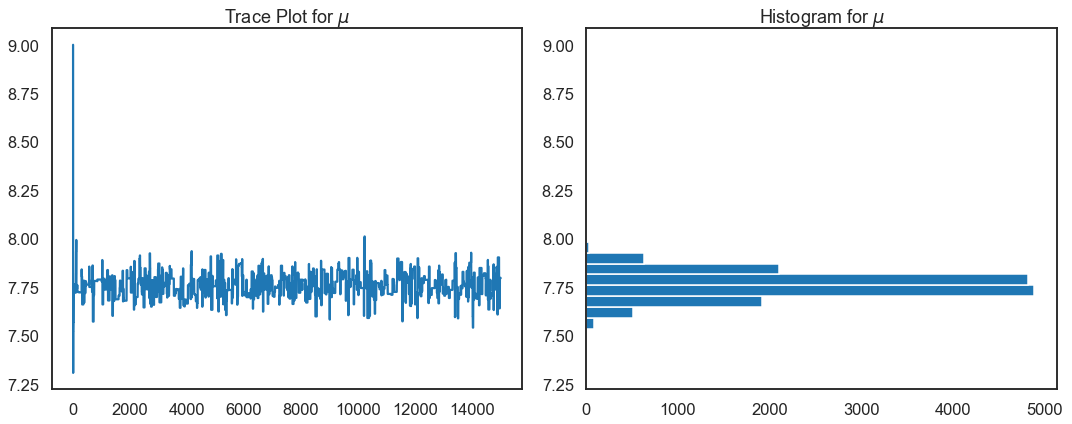

In [6]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(np.arange(chain.shape[0]),chain)
plt.title('Trace Plot for $\\mu$')

plt.subplot(122)
plt.hist(chain,orientation='horizontal',bins=30)
plt.title('Histogram for $\\mu$')

plt.tight_layout()
plt.show()


In [7]:
print("Standard Error of the Mean: ", chain.std()/np.sqrt(chain.shape[0]))

Standard Error of the Mean:  0.0005387529045821455


In [29]:
chain1 = sampler(data,samples=15000,mu_init=3,sigma=sigma,proposal_width=1,
                mu_prior_mu=mu_prior,mu_prior_sd = sigma_prior)
chain2 = sampler(data,samples=15000,mu_init=2,sigma=sigma,proposal_width=2,
                mu_prior_mu=mu_prior,mu_prior_sd = sigma_prior)
chain3 = sampler(data,samples=25000,mu_init=3,sigma=sigma,proposal_width=3,
                mu_prior_mu=mu_prior,mu_prior_sd = sigma_prior)


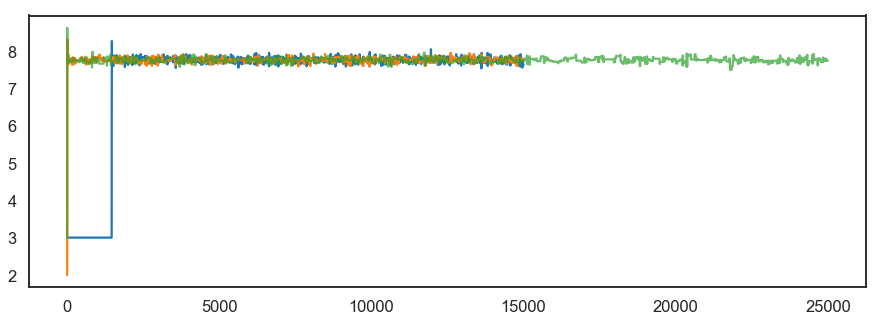

In [32]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(15001),chain1)
plt.plot(np.arange(15001),chain2)
plt.plot(np.arange(25001),chain3,alpha=.7)

In [132]:
burn_in = 1000
length = 15000

n = chain1[burn_in:burn_in+length].shape[0]

W = (chain1[burn_in:burn_in+length].std()**2 + chain2[burn_in:burn_in+length].std()**2 + chain3[burn_in:burn_in+length].std()**2)/2
mean1 = chain1[burn_in:burn_in+length].mean()
mean2 = chain2[burn_in:burn_in+length].mean()
mean = (mean1 + mean2)/2
B = n * ((mean1 - mean)**2 + (mean2 - mean)**2)
var_theta = (1 - 1/n) * W + 1/n*B
print("Gelmen-Rubin Diagnostic: ", np.sqrt(var_theta/W))

Gelmen-Rubin Diagnostic:  1.0173878185381533


# Problem 4 - Bootstrap Method

In [239]:
import scipy.stats
from scipy.stats import pearsonr
import numpy as np


In [240]:
dataset = pd.read_csv(r"C:\Users\anmol\Downloads\mtcars_hw3.csv")

In [266]:
# mpg = np.array(mpg)
# hp = np.array(hp)
# mpg = dataset.iloc[:,0:1]
# hp = dataset.iloc[:,1:2]
# mpg = np.asmatrix(mpg)
# hp = np.asmatrix(hp)
# r,p = pearsonr(mpg,hp)
# print(r,p)
mpg_hp = dataset[['mpg', 'hp']]
mpg_hp = np.array(mpg_hp)

In [267]:
corr = dataset[['mpg', 'hp']].corr()
corr = np.array(corr)

In [268]:
correlation = (corr[0][1])
Boot = 1000
N = len(X)
Y = np.zeros(Boot)
arrays = np.arange(1,N)

In [270]:
#Bootstrap method to calculate the estimate of standard error
for b in range(Boot):
    i = np.random.choice(arrays, size = N, replace = True)
    mpg = mpg_hp[:,0][i]
    hp = mpg_hp[:,1][i]
    z = np.array((mpg,hp))
    samples_correlation = np.array(pd.DataFrame(z.T).corr())
    Y[b] = samples_correlation[0][1]


IndexError: index 430 is out of bounds for axis 0 with size 32

In [265]:
# print(mpg_hp[:,0][i])
# print(z)
# print(i)
print(Y[b]) # correlation of b
print(np.mean(Y[b] - correlation))# bootstrap bias of our sample
print(np.std(samples_correlation)/N ) # bootstrap std. error  of our sample.

0.0
0.7761683718265863


NameError: name 'samples_correlation' is not defined

# Problem 4 - Jackknife estimate

In [249]:
def correlation_coeff(a):
    c = pd.DataFrame(x).corr()
    c = np.array(c)
    answer = c[0][1]
    return np.array(ans)

In [250]:
No = len(mpg_hp)

In [251]:
mpg = mpg_hp[:,0]
hp = mpg_hp[:,1]

In [252]:
jacktheta = np.zeros(No)
for i in range(No):
    idx = np.arange(No)
    jacktheta[i] = np.corrcoef(mpg[idx!=i],hp[idx!=i])[0][1]

In [253]:
jacktheta

array([-0.77748852, -0.77748852, -0.77498433, -0.77661607, -0.77588769,
       -0.78915351, -0.76855916, -0.7730921 , -0.77483681, -0.77970238,
       -0.78398422, -0.77413904, -0.77448579, -0.77459578, -0.7736433 ,
       -0.76891633, -0.76918297, -0.76810031, -0.7586755 , -0.77285637,
       -0.77806122, -0.78256905, -0.78353051, -0.76478555, -0.77662606,
       -0.76516544, -0.77045455, -0.79071475, -0.78093503, -0.77754203,
       -0.81745361, -0.77671657])

In [254]:
jackestimate = np.mean(jacktheta)
print(jackestimate)
jackbias = (No-1)*(np.mean(jacktheta)- correlation)
print(jackbias)
jack_se = np.std(jacktheta) * np.sqrt(No-1)
print (jack_se)

-0.7765919709205702
-0.013131571913501783
0.05509363247760185


# Problem 5 

In [255]:
dataset = pd.read_csv(r"C:\Users\anmol\Downloads\mtcars_hw3.csv")

In [256]:
mpg_hp = dataset[['mpg', 'hp']]
mpg_hp = np.array(mpg_hp)

In [257]:
corr = dataset[['mpg', 'hp']].corr()
corr = np.array(corr)
correlation = (corr[0][1])
Boot = 1000
N = len(X)
Y = np.zeros(Boot)
arrays = np.arange(1,N)

In [258]:
#Bootstrap method to calculate the estimate of standard error
for b in range(Boot):
    i = np.random.choice(arrays, size = N, replace = True)
    mpg = mpg_hp[:,0][i]
    hp = mpg_hp[:,1][i]
    z = np.array((mpg,hp))
    samples_correlation = np.array(pd.DataFrame(z.T).corr())
    Y[b] = samples_correlation[0][1]
    

IndexError: index 494 is out of bounds for axis 0 with size 32

In [259]:
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(Y[b], p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(Y[b], p))
print('%.1f%% likelihood that the confidence interval %.1f%% and %.1f%% covers the true skill of the sample' % (alpha*100, lower*100, upper*100))

95.0% likelihood that the confidence interval 0.0% and 0.0% covers the true skill of the sample


In [271]:
sample_mean = np.mean(Y[b])
sample_sd = np.std(Y[b])
quantile1 = np.quantile(samples_correlation,0.975)#at 95% CI
pivot_ci_1 = sample_mean - sample_sd*quantile1
print(pivot_ci_1)
quantile2 = np.quantile(samples_correlation,0.975)#at 95% CI
pivot_ci_2 = sample_mean - sample_sd*quantile2
print(pivot_ci_2)

NameError: name 'samples_correlation' is not defined

# Extra work

In [274]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2]

# Size of dataset
size = 1000

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

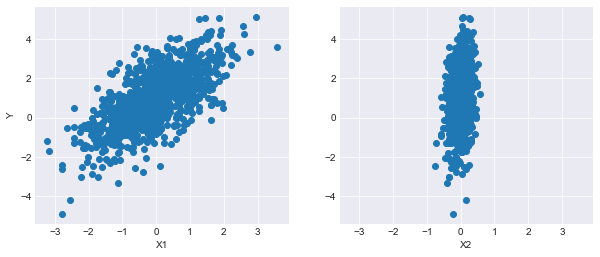

In [275]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');